# Day 3 - Model Calibration

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy.integrate import odeint
from scipy.optimize import minimize
from IPython.display import display, Math

## Defining the model
Let C be the number of tumor cells and assuming that the tumor grows exponentially with a growth rate of $a$ cells/hour. With these assumptions, the mathematical models is:
\begin{equation}
\frac{d C}{dt}=aC.
\end{equation}

In [2]:
# Let y be the vector of outputs, t the time, and p the vector of parameters
def control_tumor(y, t, p):
    return p[0] * y[0]

## Generating the data
We will generate the in silico data using the true model and adding a random perturbation

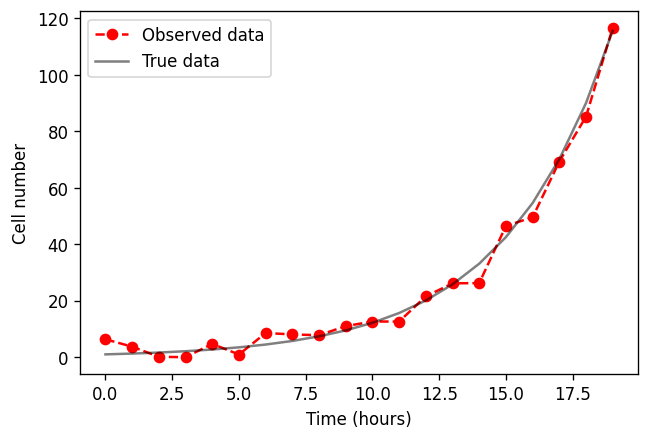

In [3]:
# Define time interval, parameter value, and initial condition
times = np.arange(0,20,1)
true_growth, true_ic = 0.25, 1
# Solving the ODE model
y = odeint(control_tumor, t=times, y0=true_ic, args=tuple([[true_growth]]))
#Adding perturbation
true_std = 3.6
#np.random.seed(20394) # For reproducibility
np.random.seed(2021) # For reproducibility
yobs = np.random.normal(y,true_std)
yobs[yobs < 0] = 0
# Plotting the true and observed data
fig, ax = plt.subplots(dpi=120)
plt.plot(times, yobs, label='Observed data', linestyle='dashed', marker='o', color='red')
plt.plot(times, y, label='True data', color='k', alpha=0.5)
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
plt.show()

## Defining the log likelihood

In [4]:
def log_likelihood(theta, times, y):
    cal_growth, cal_std = theta
    model = odeint(control_tumor, t=times, y0=y[0], args=tuple([[cal_growth]]))
    variance = cal_std*cal_std
    return -0.5 * np.sum((y - model) ** 2 / variance + np.log(variance))

Maximum likelihood estimates:
Growth rate = 0.140
Standard deviation = 11.675
Growth rate % error = 43.997
Standard deviation % error = 224.309


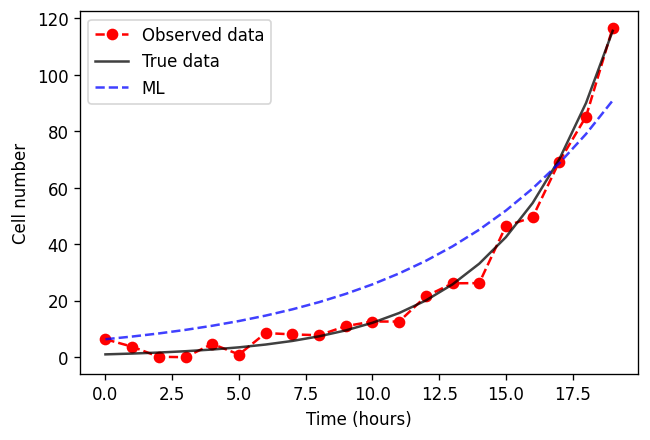

In [5]:
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0.4, 0.3])+ 0.1 * np.random.randn(2)
from scipy.optimize import Bounds
bounds = Bounds([0.0, 0.1], [1.0, 50.0])
soln = minimize(nll, initial, args=(times, yobs), bounds=bounds)
ml_growth, ml_std = soln.x

print("Maximum likelihood estimates:")
print("Growth rate = {0:.3f}".format(ml_growth))
print("Standard deviation = {0:.3f}".format(ml_std))
print("Growth rate % error = {0:.3f}".format(100*abs(ml_growth-true_growth)/true_growth))
print("Standard deviation % error = {0:.3f}".format(100*abs(ml_std-true_std)/true_std))

y_ml = odeint(control_tumor, t=times, y0=yobs[0], args=tuple([[ml_growth]]))

fig, ax = plt.subplots(dpi=120)
plt.plot(times, yobs, label='Observed data', linestyle='dashed', marker='o', color='red')
plt.plot(times, y, label='True data', color='k', alpha=0.75)
plt.plot(times, y_ml, label='ML', linestyle='dashed', color='blue', alpha=0.75)
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
plt.show()

In [6]:
def log_likelihood_ic(theta, times, y):
    cal_growth, cal_std , cal_ic = theta
    model = odeint(control_tumor, t=times, y0=cal_ic, args=tuple([[cal_growth]]))
    variance = cal_std*cal_std
    return -0.5 * np.sum((y - model) ** 2 / variance + np.log(variance))

Maximum likelihood estimates:
Growth rate = 0.253
Standard deviation = 3.064
Initial condition = 0.937
Growth rate % error = 1.044
Standard deviation % error = 14.879
Initial condition % error = 6.296


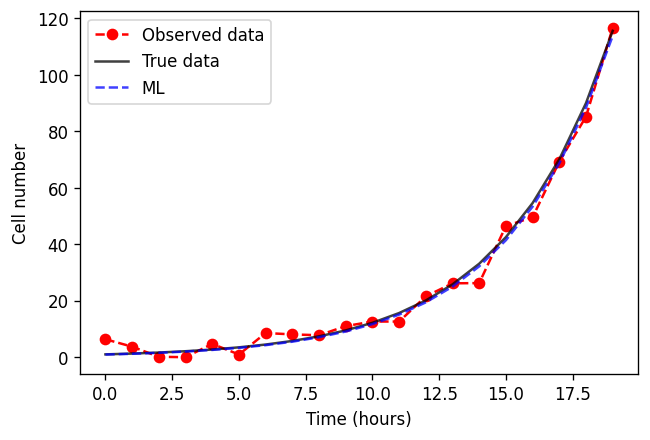

In [7]:
nll = lambda *args: -log_likelihood_ic(*args)
initial = np.array([0.4, 0.3, 5])+ 0.1 * np.random.randn(3)
from scipy.optimize import Bounds
bounds = Bounds([0.0, 0.1, 0.1], [1.0, 50.0, 20.0])
soln = minimize(nll, initial, args=(times, yobs), bounds=bounds)
ml_growth, ml_std, ml_ic = soln.x

print("Maximum likelihood estimates:")
print("Growth rate = {0:.3f}".format(ml_growth))
print("Standard deviation = {0:.3f}".format(ml_std))
print("Initial condition = {0:.3f}".format(ml_ic))
print("Growth rate % error = {0:.3f}".format(100*abs(ml_growth-true_growth)/true_growth))
print("Standard deviation % error = {0:.3f}".format(100*abs(ml_std-true_std)/true_std))
print("Initial condition % error = {0:.3f}".format(100*abs(ml_ic-true_ic)/true_ic))

y_ml = odeint(control_tumor, t=times, y0=ml_ic, args=tuple([[ml_growth]]))

fig, ax = plt.subplots(dpi=120)
plt.plot(times, yobs, label='Observed data', linestyle='dashed', marker='o', color='red')
plt.plot(times, y, label='True data', color='k', alpha=0.75)
plt.plot(times, y_ml, label='ML', linestyle='dashed', color='blue', alpha=0.75)
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
plt.show()

In [8]:
def log_prior(theta):
    cal_growth, cal_std, cal_ic = theta
    if 0.0 < cal_growth < 1.0 and 0.1 < cal_std < 50.0 and 0.1 < cal_ic < 20.0:
        return 0.0
    return -np.inf

In [9]:
def log_probability(theta, times, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_ic(theta, times, y)

In [10]:
mean_g = np.array([0.4, 0.3, 10])
pos = mean_g + 1e-1 * np.random.randn(32,3)

In [11]:
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(times, yobs))
sampler.run_mcmc(pos, 7100, progress=True);

  0%|          | 0/7100 [00:00<?, ?it/s]/home/ernesto/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 7100/7100 [00:43<00:00, 162.06it/s]


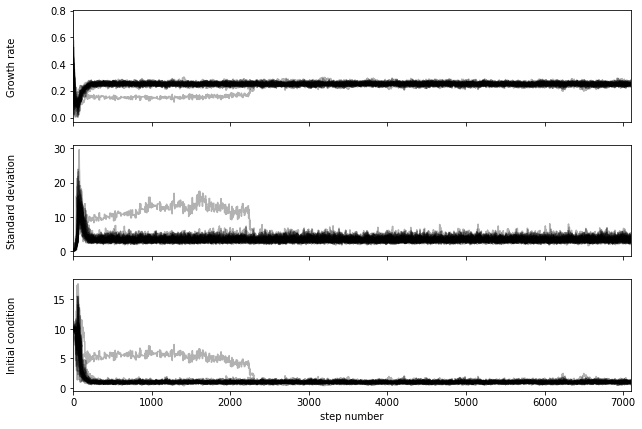

In [12]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Growth rate", "Standard deviation", "Initial condition"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [13]:
tau = sampler.get_autocorr_time()
print(tau)

[111.39588303  64.9406165  141.95728663]


In [14]:
flat_samples = sampler.get_chain(discard=450, thin=15, flat=True)
print(flat_samples.shape)

(14176, 3)


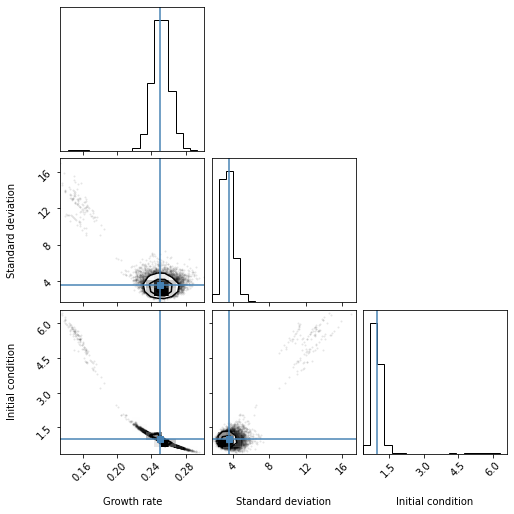

In [15]:
fig = corner.corner(flat_samples, labels=labels, truths=[true_growth, true_std, true_ic]);

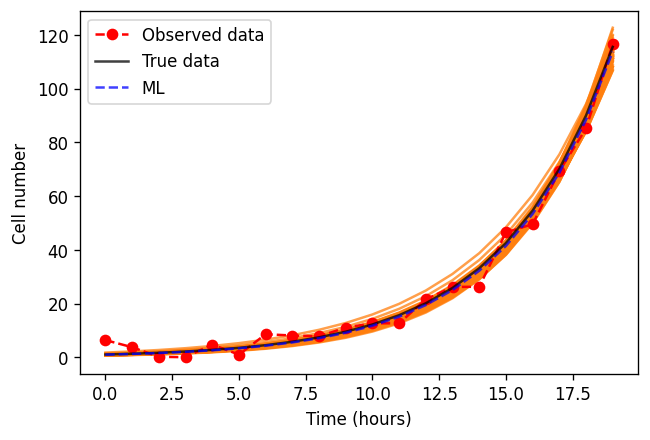

In [16]:
fig, ax = plt.subplots(dpi=120)
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    y_sp = odeint(control_tumor, t=times, y0=sample[2], args=tuple([[sample[0]]]))
    plt.plot(times, y_sp, 'C1', alpha=0.75)
plt.plot(times, yobs, label='Observed data', linestyle='dashed', marker='o', color='red')
plt.plot(times, y, label='True data', color='k', alpha=0.75)
plt.plot(times, y_ml, label='ML', linestyle='dashed', color='blue', alpha=0.75)
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
plt.show()

In [17]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [18]:
print("Bayesian Calibration:")
mcmc = np.percentile(flat_samples[:, 0], [16, 50, 84])
print("Growth rate = {0:.3f}".format(mcmc[1]))
print("Growth rate % error = {0:.3f}".format(100*abs(mcmc[1]-true_growth)/true_growth))
mcmc = np.percentile(flat_samples[:, 1], [16, 50, 84])
print("Standard deviation = {0:.3f}".format(mcmc[1]))
print("Standard deviation % error = {0:.3f}".format(100*abs(mcmc[1]-true_std)/true_std))
mcmc = np.percentile(flat_samples[:, 2], [16, 50, 84])
print("Initial condition = {0:.3f}".format(mcmc[1]))
print("Initial condition % error = {0:.3f}".format(100*abs(mcmc[1]-true_ic)/true_ic))

Bayesian Calibration:
Growth rate = 0.251
Growth rate % error = 0.540
Standard deviation = 3.415
Standard deviation % error = 5.135
Initial condition = 0.959
Initial condition % error = 4.128
